In [16]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [17]:
from functions import *

## **Import the EEG Data and set the Global Variables**

In [18]:
chan_name = ['POz', 'PO3', 'PO8', 'PO7', 'PO4', 'O1', 'Oz', 'O2']
fs, lf, hf = 250, 1, 30 #Hz

eeg_data = []

eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Side', chan_name=chan_name))
eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment1_ExG.csv', title='e1_Overlapped', chan_name=chan_name))

eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_Colour', chan_name=chan_name))
eeg_data.append(EEG_Data('data/BinocularVR-22March/experiment2_ExG.csv', title='e2_BW', chan_name=chan_name))

![Electrode Placement](readme_images/Electrode.png)
### Automatically assign channels to left, right and midline


In [19]:
# left hemisphere -> odd numbers (1,3,5,7) 
left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
# right hemisphere -> even numbers (2,4,6,8)
right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
# midline -> z
midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']

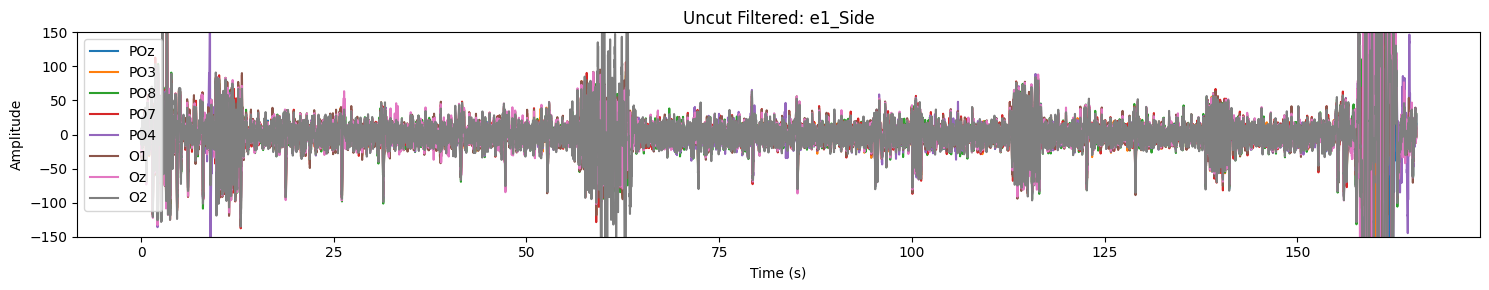

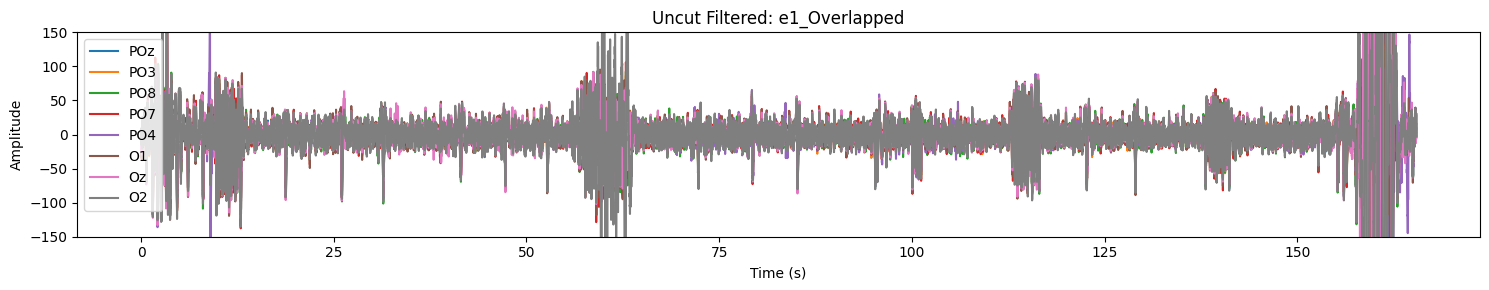

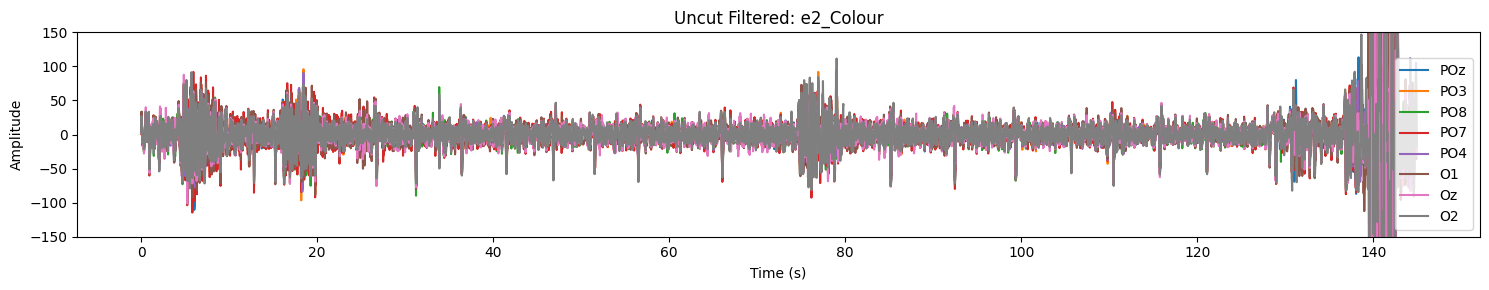

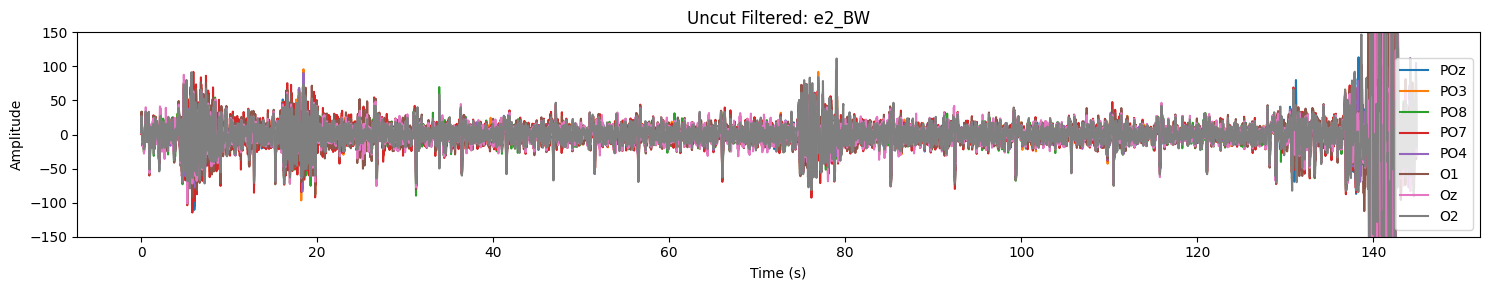

In [20]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("Uncut Filtered: "+eeg.title))

In [21]:
# TODO: automate this. look into the labstreaming layers and the markers

eeg_data[0].cut_signal(15, 55, cut_to=True)
eeg_data[1].cut_signal(65, 115, cut_to=True)
eeg_data[2].cut_signal(22, 70, cut_to=True)
eeg_data[3].cut_signal(84, 125, cut_to=True)

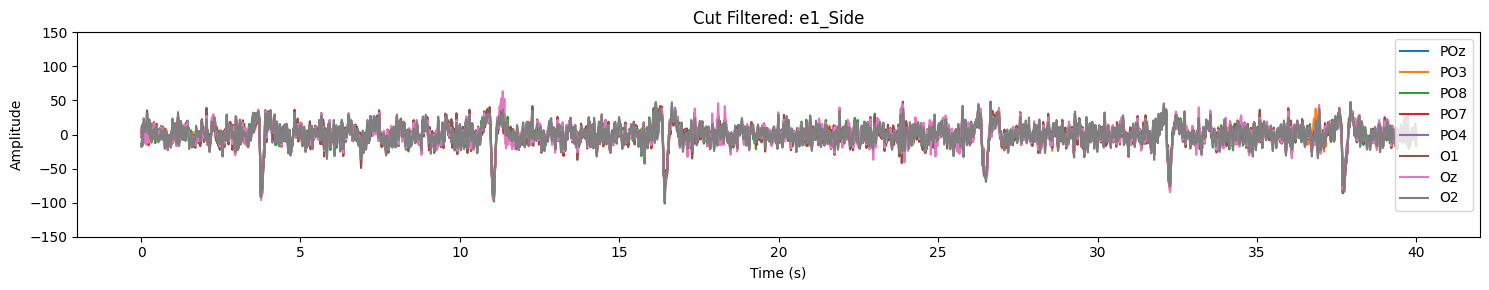

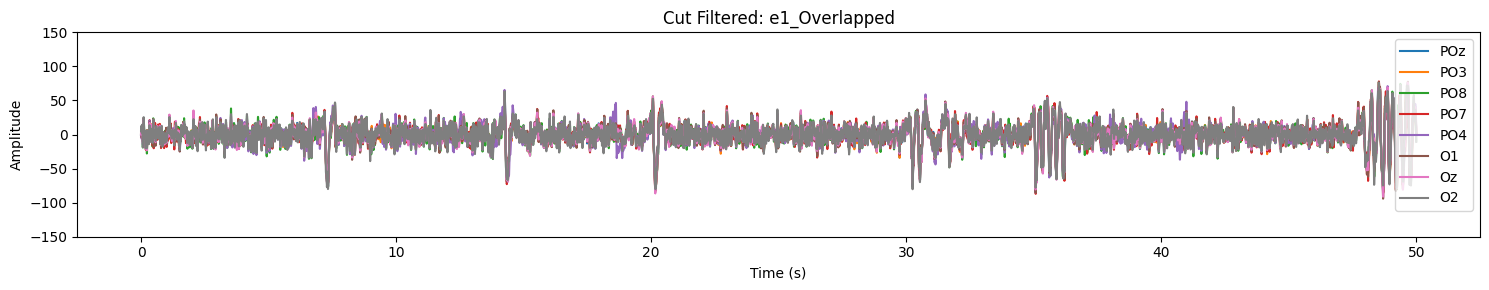

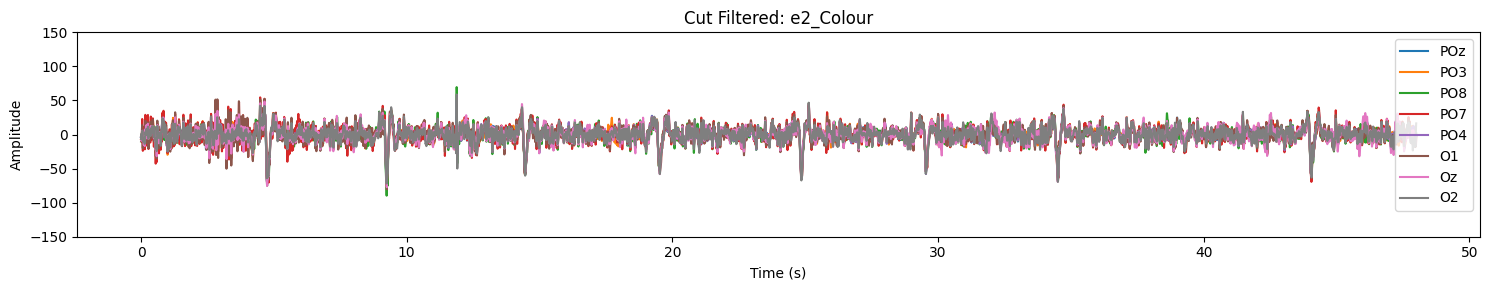

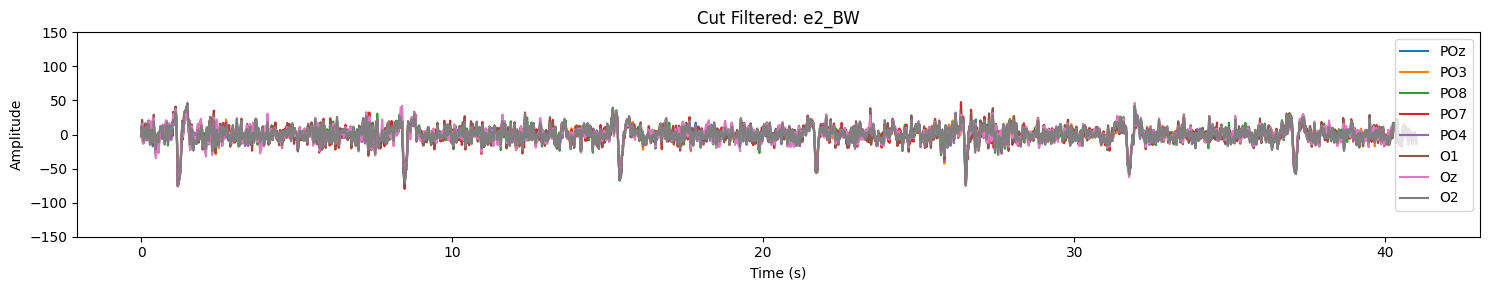

In [22]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("Cut Filtered: "+eeg.title))

In [23]:
psd_plot_interactive(eeg_data, chan_name, nperseg_max=20, nfft_max=20, fig_x=15,fig_y=3)

interactive(children=(IntSlider(value=20, description='nperseg*fs:', max=20, min=1), IntSlider(value=20, descr…

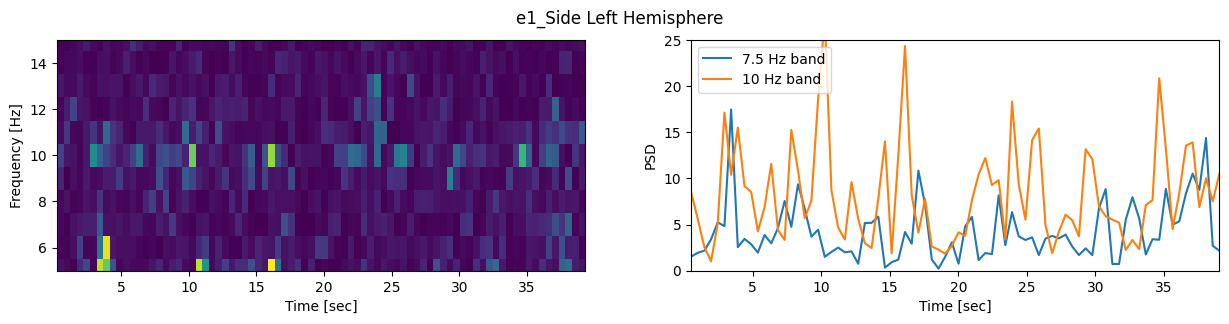

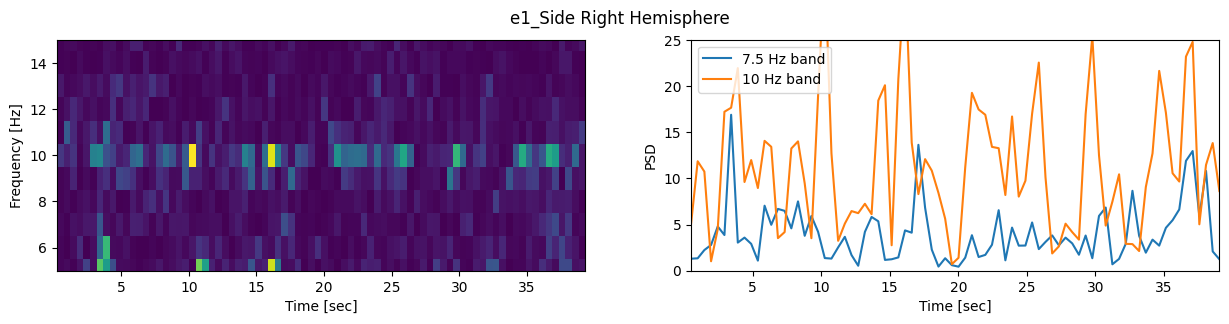

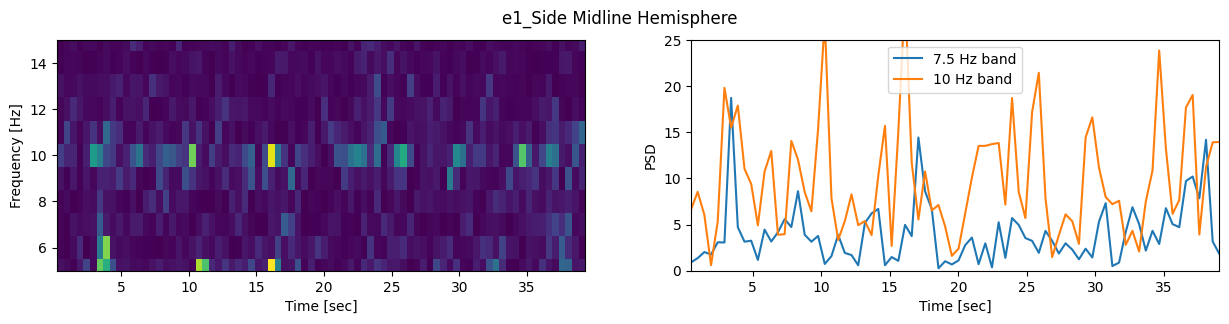

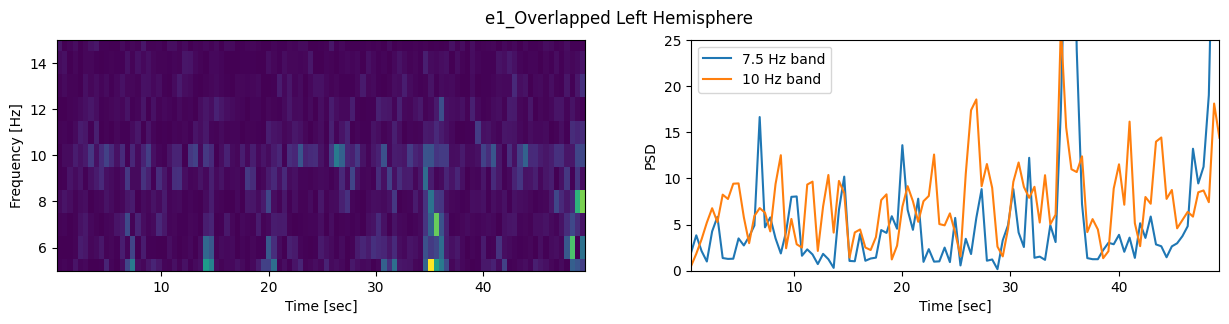

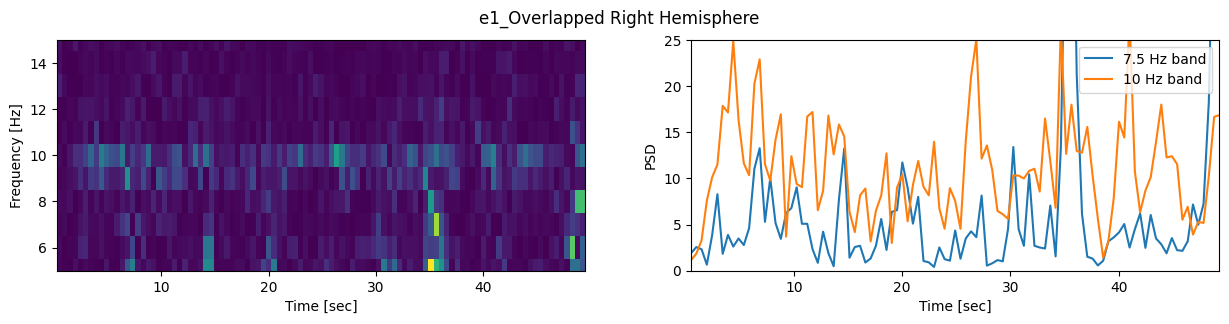

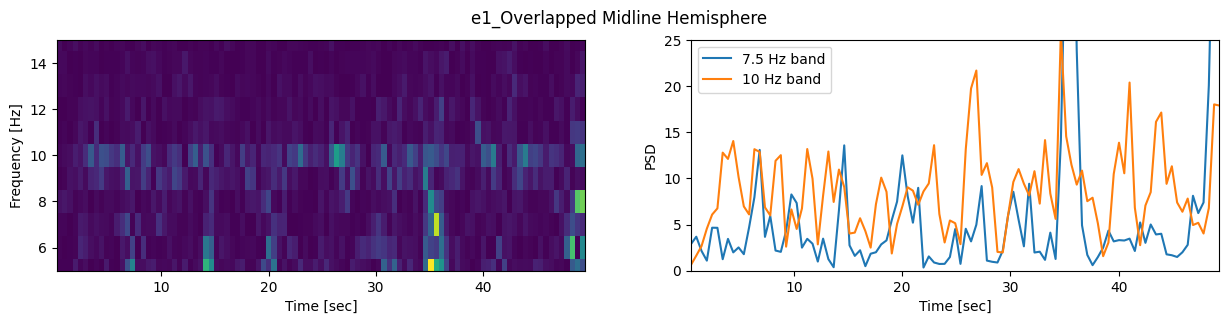

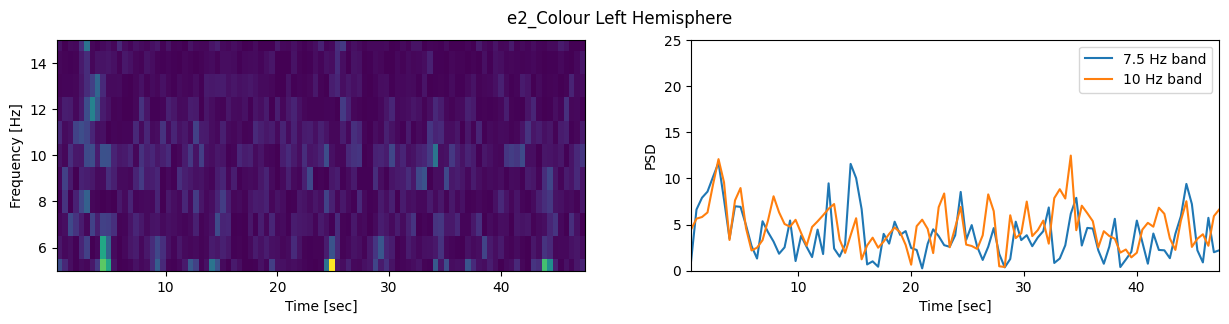

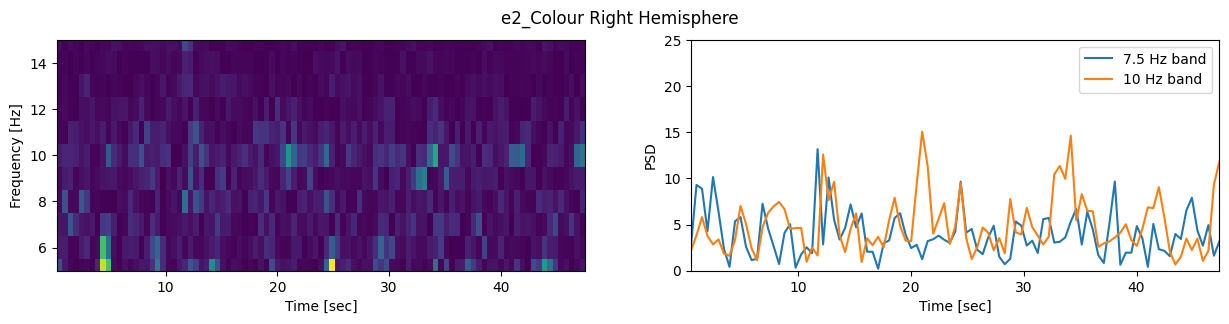

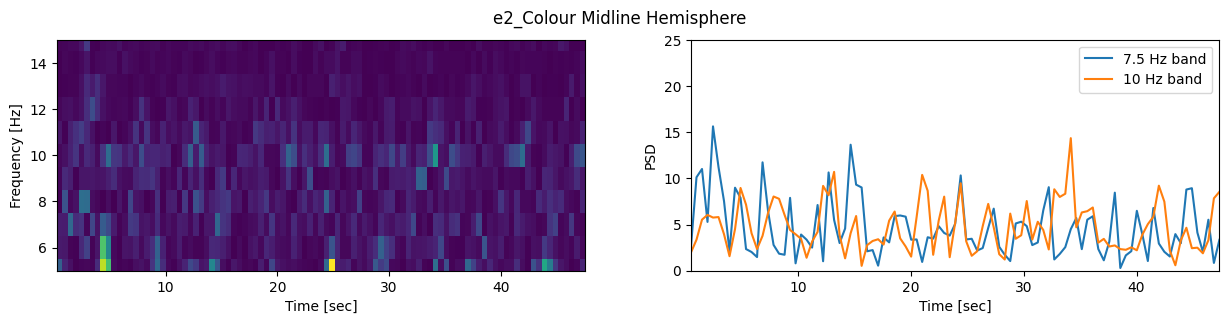

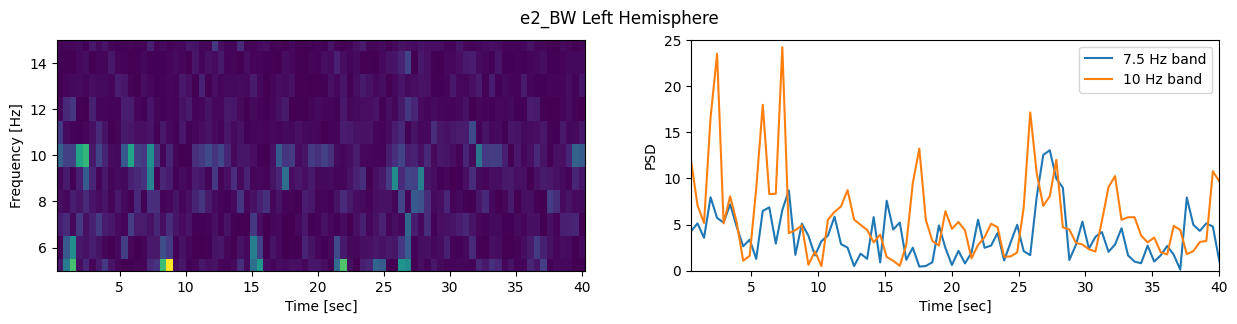

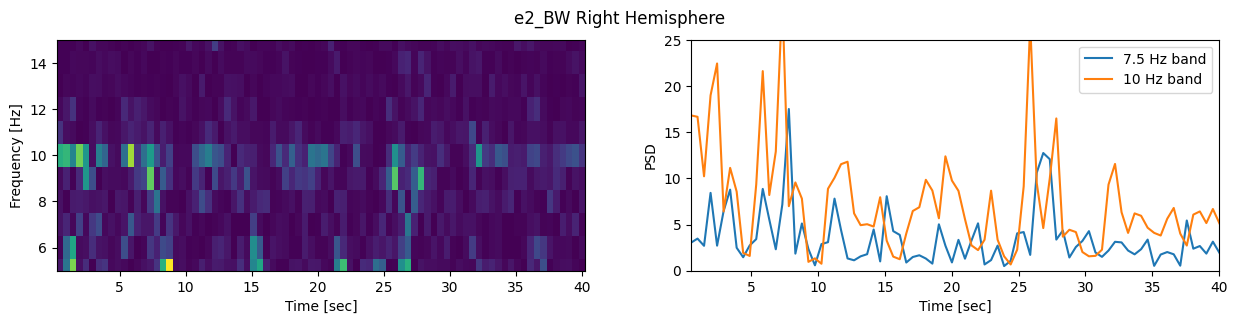

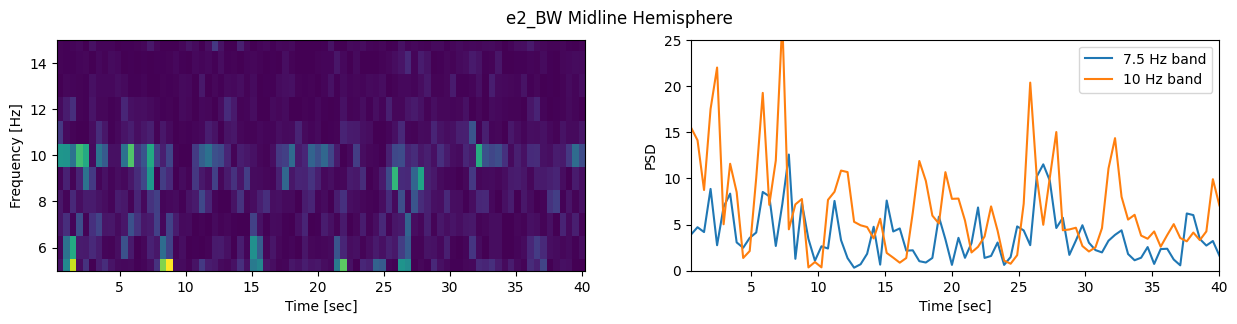

In [24]:
def plot_spectrogram_and_bands(filt_signal, title, f_min, f_max, sampling_freq, band_freqs):
    # Compute spectrogram using scipy's signal.spectrogram function
    frequencies, times, spectrogram = signal.spectrogram(filt_signal, fs=sampling_freq, nperseg=fs, noverlap=128, scaling='spectrum', mode='psd', nfft=fs)

    # Mask the spectrogram to only show frequencies in the desired range
    mask = (frequencies >= f_min) & (frequencies <= f_max)
    spectrogram_masked = spectrogram[mask, :]
    frequencies_masked = frequencies[mask]

    # Plot the spectrogram using matplotlib
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(title)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.pcolormesh(times, frequencies_masked, spectrogram_masked)
    ax1.set_ylim(f_min, f_max)
    ax1.set_ylabel('Frequency [Hz]')
    ax1.set_xlabel('Time [sec]')
    
    # Compute the average PSD in the frequency bands of interest at each time point
    psds = []
    for band_freq in band_freqs:
        band_mask = (frequencies >= band_freq-1) & (frequencies <= band_freq+1)
        psd = np.mean(spectrogram[band_mask, :], axis=0)
        psds.append(psd)

    # Plot the PSDs in the frequency bands of interest through time
    ax2 = fig.add_subplot(1, 2, 2)
    for i, psd in enumerate(psds):
        ax2.plot(times, psd, label=f'{band_freqs[i]} Hz band')
    ax2.set_xlim(times[0], times[-1])
    ax2.set_ylim(0, 25)
    ax2.set_xlabel('Time [sec]')
    ax2.set_ylabel('PSD')
    ax2.legend()
    
    plt.show()


# Example usage
time = np.arange(0, 50, 1/250)

# take the average of the 8 channels in filtered_signal

for eeg in eeg_data:
    
    # plot the spectrogram and the PSDs in the frequency bands of interest through time
    # seperate the signal into left and right hemisphere
    left_hemisphere_signal = eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:]
    right_hemisphere_signal = eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:]
    midline_hemisphere_signal = eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:]
    # take the average of the 8 channels in filtered_signal
    left_hemisphere_signal = np.mean(left_hemisphere_signal, axis=0)
    right_hemisphere_signal = np.mean(right_hemisphere_signal, axis=0)
    midline_hemisphere_signal = np.mean(midline_hemisphere_signal, axis=0)
    # plot the spectrogram and the PSDs in the frequency bands of interest through time

    plot_spectrogram_and_bands(left_hemisphere_signal, title=(eeg.title+" Left Hemisphere"), f_min=5, f_max=15, sampling_freq=250, band_freqs=[7.5,10])
    plot_spectrogram_and_bands(right_hemisphere_signal, title=(eeg.title+" Right Hemisphere"), f_min=5, f_max=15, sampling_freq=250, band_freqs=[7.5,10])
    plot_spectrogram_and_bands(midline_hemisphere_signal, title=(eeg.title+" Midline Hemisphere"), f_min=5, f_max=15, sampling_freq=250, band_freqs=[7.5,10])
    

In [25]:
# %%capture 
# # get the min stimulus frequency from the eeg data
# min_freq = 5
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if eeg.stimulus_frequency <= min_freq:
#             min_freq = eeg.stimulus_frequency - 2

# # get the max stimulus frequency from the eeg data
# max_freq = 15
# for eeg in eeg_data:
#     if eeg.stimulus_frequency:
#         if eeg.stimulus_frequency >= max_freq:
#             max_freq = eeg.stimulus_frequency+2

# freqs = np.arange(min_freq, max_freq, .3)
# n_cycles = freqs
# t_min, t_max = 1, 6


# # Get the class names
# class_names = [eeg.title for eeg in eeg_data]

# times = np.linspace(t_min, t_max, eeg_data[0].epochs.shape[2])

# # compute power for each epoch
# power = []
# for eeg in eeg_data:
#     power.append(mne.time_frequency.tfr_array_morlet(eeg.epochs, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power'))

# power_stack = np.stack(power)

# for pow in power:
#     mne.baseline.rescale(pow, times, (None, times[0]), mode='mean', copy=False)
    
# power = power_stack

In [26]:
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_chan, len(class_names), figsize=(15, 15))
for j in range(len(class_names)):
    for i in range(n_chan):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
        if eeg_data[j].stimulus_frequency:
            ax[i, j].axhline(y=eeg_data[j].stimulus_frequency, linestyle='--', color='white')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()

NameError: name 'times' is not defined